In [1]:
%%capture
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes

!yes | pip3 uninstall pandas
!yes | pip3 uninstall geopandas

!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;
!pip3 install pandas
!pip3 install geopandas
!pip3 install matplotlib
!pip3 install osmapi
!pip3 install geopy
!pip3 install plotly
!pip3 install folium

In [2]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import random
import pandas as pd
import osmapi as osm
import time
from collections import deque
from tqdm import tqdm
from itertools import islice

In [3]:
from utilities import *

# Start of Graph Formulation

In [4]:
place = 'North York, Ontario, Canada'
G = ox.graph_from_place(place)
# fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)  # display the city of North York 

In [5]:
nodes, edges = ox.graph_to_gdfs(G)      # Convert node and edge GeoDataFrames to a MultiDiGraph.

# Using OpenStreetMap node IDs API

This highlights many amenities. Seems to be a good option here.

In [6]:
class Amenity: 
  def __init__(self, amenity, lat, lon, name, osmid, nearestNode):
    self.amenity = amenity
    self.lat = float(lat)
    self.lon = float(lon)
    self.name = name
    self.osmid = osmid 
    self.nearestNode = nearestNode

In [7]:
# Get all the important things we need to highlight on the map
tags = {
    'amenity':['hospital', 'fire_station'],
}
emergency_locations = ox.geometries_from_place(place, tags=tags)
# print(emergency_locations)
df = pd.DataFrame(emergency_locations)  # data frame 
dic = df.to_dict()

In [8]:
amenities = []

api = osm.OsmApi() # using this to find lat and lon
for i in range(len(dic['unique_id'])):
  if ("node" in dic['unique_id'][i]):
    nodeId= dic['osmid'][i]
  elif ("way" in dic['unique_id'][i]):
    nodeId = dic['nodes'][i][0]

  id_info = api.NodeGet(nodeId)
  point = (id_info['lat'], id_info['lon']) # lat (y), lon (x) 
  pt_nearest_node_euc = ox.get_nearest_node(G, point, method='euclidean')
  
  # amenity, lat, lon, name, osmid, nearestNode
  amenities.append(Amenity(dic['amenity'][i], id_info['lat'], id_info['lon'], 
                           dic['name'][i], dic['osmid'][i], pt_nearest_node_euc))
  

In [9]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def node_color_and_size(amenities, nodes):
  node_colors = ['w'] * len(nodes)
  node_size = [0] * len(nodes)
  for i in range(len(amenities)): 
    idx = find_element_in_list(amenities[i].nearestNode, nodes)
    if (idx != -1):
      if (amenities[i].amenity == 'fire_station'):
        node_colors[idx] = 'b'
      if (amenities[i].amenity == 'hospital'):
        node_colors[idx] = 'r'
      node_size[idx] = 10
  return node_colors, node_size

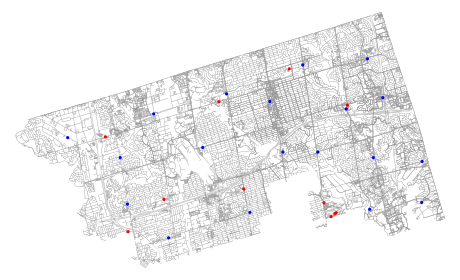

In [10]:
all_nodes = list(nodes.to_dict()['osmid'].keys())
nc, ns = node_color_and_size(amenities, all_nodes)

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

Stategy going forward: 
1. Heat map of traafic data 
2. Implement the algorithm - currently we are utilizing the algorithm from prof

# The Algorithm

## -------- A* -----------

In [11]:
# first define the origin/source nodes as Node
# origin = Node(graph = G, osmid = amenities[0].nearestNode)
# destination = Node(graph = G, osmid = amenities[3].nearestNode)

In [12]:
def A_star(G, origin, destination):
    toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

    %time
    route = []
    frontier = list()

    bar = tqdm(total=len(G)) # for the progress bar

    frontier.append(origin)
    explored = set()
    found = False

    while frontier and not found:
        bar.update(1); time.sleep(0.05)

        # choose a node based on its heuristic value
        node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
        frontier.remove(node)
        explored.add(node)

        # expand its children
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    found = True
                    continue
                frontier.append(child)

    bar.close()
    return route 

In [13]:
to_from_locations = []
to_from_locations.append( (Node(graph = G, osmid = amenities[0].nearestNode), 
                           Node(graph = G, osmid = amenities[3].nearestNode)))
to_from_locations.append( (Node(graph = G, osmid = amenities[1].nearestNode), 
                           Node(graph = G, osmid = amenities[4].nearestNode)))
to_from_locations.append( (Node(graph = G, osmid = amenities[2].nearestNode), 
                           Node(graph = G, osmid = amenities[7].nearestNode)))

routes = []

for i in range(len(to_from_locations)):
    routes.append(A_star(G, to_from_locations[i][0], to_from_locations[i][1]))
    

  0%|          | 3/35552 [00:00<19:49, 29.88it/s]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


  0%|          | 3/35552 [00:00<21:15, 27.88it/s]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


  0%|          | 3/35552 [00:00<20:15, 29.25it/s]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


  2%|▏         | 748/35552 [00:39<30:37, 18.94it/s]


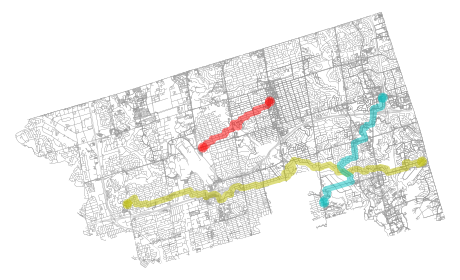

In [40]:
number_of_colors = len(routes)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

fig, ax = ox.plot_graph_routes(G, routes, route_colors=color, route_linewidth=6, node_size=0, edge_linewidth=0.2, bgcolor = 'white')

--------------------------------------------------------------------------

# **TESTING ONWARDS** - Ignore

In [15]:
import matplotlib.cm as cm

def get_colors(n, cmap="viridis", start=0.0, stop=1.0, alpha=1.0, return_hex=False):
    """
    Get n evenly-spaced colors from a matplotlib colormap.
    Parameters
    ----------
    n : int
        number of colors
    cmap : string
        name of a matplotlib colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    alpha : float
        opacity, the alpha channel for the RGBa colors
    return_hex : bool
        if True, convert RGBa colors to HTML-like hexadecimal RGB strings. if
        False, return colors as (R, G, B, alpha) tuples.
    Returns
    -------
    color_list : list
    """
    color_list = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    if return_hex:
        color_list = [colors.to_hex(c) for c in color_list]
    else:
        color_list = [(r, g, b, alpha) for r, g, b, _ in color_list]
    return color_list

get_colors(7)

[(0.267004, 0.004874, 0.329415, 1.0),
 (0.267968, 0.223549, 0.512008, 1.0),
 (0.190631, 0.407061, 0.556089, 1.0),
 (0.127568, 0.566949, 0.550556, 1.0),
 (0.20803, 0.718701, 0.472873, 1.0),
 (0.565498, 0.84243, 0.262877, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0)]

['#F273CC', '#DB2184', '#760B37']


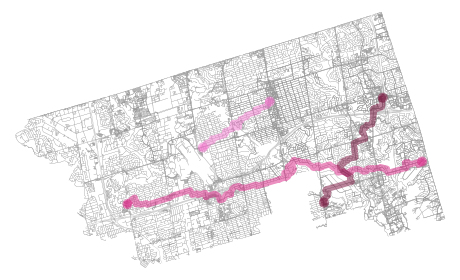

In [22]:
# rc = ['r', 'y', 'c']

import matplotlib.pyplot as plt
import random

number_of_colors = len(routes)

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(color)

fig, ax = ox.plot_graph_routes(G, routes, route_colors=color, route_linewidth=6, node_size=0, edge_linewidth=0.2, bgcolor = 'white')